## Clustering with UMAPs
Clustering objects can be challenging when working with many parameters, in particular when interacting with data manually. To reduce the number of parameters, dimensionality reduction techniques such as the Uniform Manifold Approximation Projection (UMAP) have been developed. In this notebook we use the technique to differentiate nuclei in an image which are mitotic from those which are not mitotic.

See also
* [UMAP Documentation](https://umap-learn.readthedocs.io/)
* [McInnes, L, Healy, J, UMAP: Uniform Manifold Approximation and Projection for Dimension Reduction, ArXiv e-prints 1802.03426, 2018](https://arxiv.org/abs/1802.03426)

In [1]:
from skimage.data import human_mitosis
from napari_segment_blobs_and_things_with_membranes import voronoi_otsu_labeling
from napari_simpleitk_image_processing import label_statistics
from sklearn.preprocessing import StandardScaler
import numpy as np
import umap
import seaborn
import pyclesperanto_prototype as cle
import matplotlib.pyplot as plt

## Example data
First, we load the example image (taken from the [scikit-image examples](https://scikit-image.org/docs/stable/auto_examples/applications/plot_human_mitosis.html)) showing human cell nuclei.

cl.OCLArray([[ 8.,  8.,  8., ..., 63., 78., 75.],
       [ 8.,  8.,  7., ..., 67., 71., 71.],
       [ 9.,  8.,  8., ..., 53., 64., 66.],
       ...,
       [ 8.,  9.,  8., ..., 17., 24., 59.],
       [ 8.,  8.,  8., ..., 17., 22., 55.],
       [ 8.,  8.,  8., ..., 16., 18., 38.]], dtype=float32)
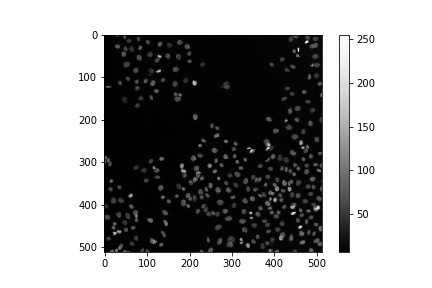
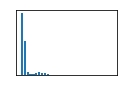

In [2]:
image = cle.asarray(human_mitosis())
image

cl.OCLArray([[  0,   0,   0, ..., 314, 314, 314],
       [  0,   0,   0, ..., 314, 314, 314],
       [  0,   0,   0, ..., 314, 314, 314],
       ...,
       [  0,   0,   0, ...,   0,   0, 320],
       [  0,   0,   0, ...,   0,   0, 320],
       [  0,   0,   0, ...,   0,   0, 320]], dtype=uint32)
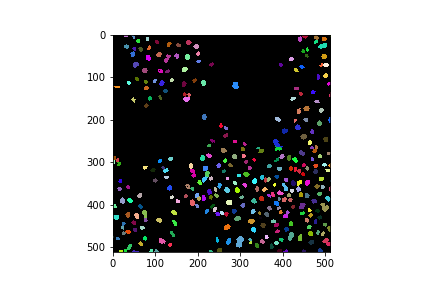

In [3]:
labels = cle.voronoi_otsu_labeling(image, spot_sigma=2.5, outline_sigma=0)
labels

## Feature extraction
We then measure properties of the nuclei such as intensity, size, shape, perimeter and moments.

In [4]:
nuclei_statistics = label_statistics(image, labels, 
                                     intensity=True, 
                                     size=True, 
                                     shape=True, 
                                     perimeter=True,
                                     moments=True)
nuclei_statistics.head()

,label,maximum,mean,median,minimum,sigma,sum,variance,elongation,feret_diameter,...,number_of_pixels_on_border,perimeter,perimeter_on_border,perimeter_on_border_ratio,principal_axes0,principal_axes1,principal_axes2,principal_axes3,principal_moments0,principal_moments1
0,1,83.0,69.886364,73.359375,48.0,9.890601,3075.0,97.823996,1.858735,9.486833,...,10,25.664982,10.0,0.389636,0.998995,-0.044825,0.044825,0.998995,1.926448,6.655680
1,2,46.0,42.125000,43.328125,38.0,2.748376,337.0,7.553571,0.000000,7.000000,...,8,15.954349,8.0,0.501431,1.000000,0.000000,0.000000,1.000000,0.000000,5.250000
2,3,53.0,44.916667,45.265625,38.0,4.461111,539.0,19.901515,3.609511,6.000000,...,7,14.843629,7.0,0.471583,1.000000,0.000000,0.000000,1.000000,0.243056,3.166667
3,4,92.0,65.603175,65.609375,38.0,14.475273,4133.0,209.533538,1.212933,10.000000,...,7,29.687257,7.0,0.235791,0.914511,0.404561,-0.404561,0.914511,4.227271,6.219189
4,5,59.0,46.315068,46.234375,38.0,5.065890,3381.0,25.663242,1.249507,11.401754,...,9,34.264893,9.0,0.262660,0.363116,-0.931744,0.931744,0.363116,5.001247,7.808286


In [5]:
# list all columns we measured
nuclei_statistics.keys()

Index(['label', 'maximum', 'mean', 'median', 'minimum', 'sigma', 'sum',
       'variance', 'elongation', 'feret_diameter', 'flatness', 'roundness',
       'equivalent_ellipsoid_diameter_0', 'equivalent_ellipsoid_diameter_1',
       'equivalent_spherical_perimeter', 'equivalent_spherical_radius',
       'number_of_pixels', 'number_of_pixels_on_border', 'perimeter',
       'perimeter_on_border', 'perimeter_on_border_ratio', 'principal_axes0',
       'principal_axes1', 'principal_axes2', 'principal_axes3',
       'principal_moments0', 'principal_moments1'],
      dtype='object')

## Feature selection
In the image it is obvious that dividing nuclei are brighter than others. Furthermore, they apper elongated. Thus, we select intensity and shape-based features.

In [6]:
selected_table = nuclei_statistics[
    [
        "mean",
        "variance",
        "elongation",
    ]
]

selected_statistics = selected_table.values

## Standard scaling
We then scale those measurements so that intensity levels and distances can be interpreted in a balanced way ([Read more](machine_learning_basics.scaling)). 

In [7]:
scaled_statistics = StandardScaler().fit_transform(selected_statistics)

type(scaled_statistics), scaled_statistics.shape

(numpy.ndarray, (320, 3))

## Plotting
For demonstration purposes, we plot the three selected features against each other. 

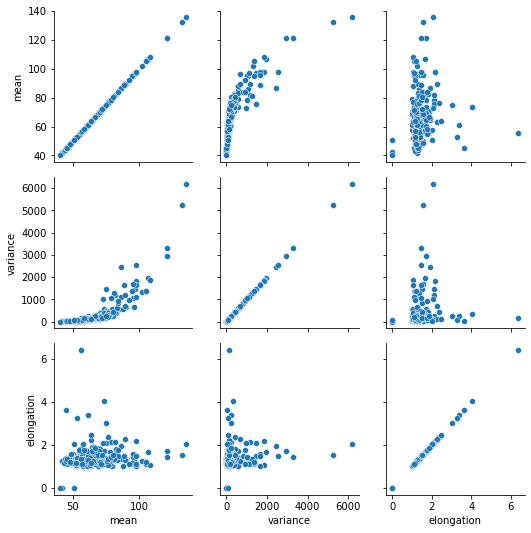

In [8]:
def hide_current_axis(*args, **kwds):
    plt.gca().set_visible(False)

g = seaborn.PairGrid(selected_table)
g.map(seaborn.scatterplot)

From these plots, one could presume that datapoints with high mean intensity, variance and/or elongation are mitotic. However, there is no clear group of data points that are characteristically different from others, which could be easily differentiated.

## Dimensionality reduction
To demonstrate the UMAP algorithm, we now reduce these three dimensions to two.

In [9]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(scaled_statistics)
type(embedding), embedding.shape

(numpy.ndarray, (320, 2))

<AxesSubplot:>

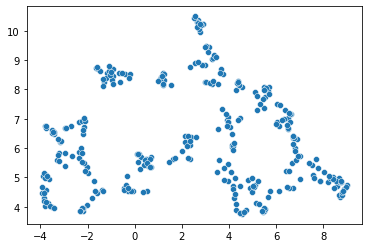

In [10]:
seaborn.scatterplot(x=embedding[:, 0], 
                    y=embedding[:, 1])

## A note on repeatability
The algorithm behind the UMAP is partially a non-deterministic. Thus, if you run the same code as above again, the result might look slightly different.

<AxesSubplot:>

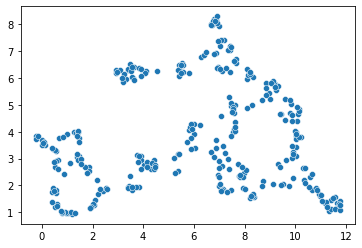

In [11]:
reducer = umap.UMAP()
embedding2 = reducer.fit_transform(scaled_statistics)

seaborn.scatterplot(x=embedding2[:, 0], 
                    y=embedding2[:, 1])

This limitation can be circumvented by providing a non-random seed `random_state`. However, it does not solve the general limitation. If our input data is slightly different, e.g. coming from a different image showing different cells, we may not receive the same UMAP result.

<AxesSubplot:>

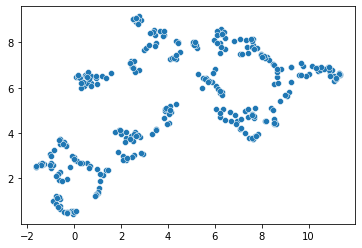

In [12]:
reducer = umap.UMAP(random_state=42)
embedding3 = reducer.fit_transform(scaled_statistics)

seaborn.scatterplot(x=embedding3[:, 0], 
                    y=embedding3[:, 1])

<AxesSubplot:>

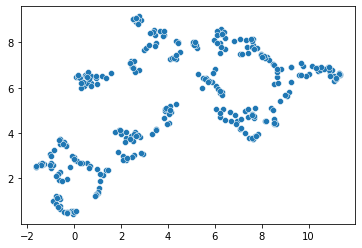

In [13]:
reducer = umap.UMAP(random_state=42)
embedding4 = reducer.fit_transform(scaled_statistics)

seaborn.scatterplot(x=embedding4[:, 0], 
                    y=embedding4[:, 1])

In [14]:
nuclei_statistics["UMAP1"] = embedding4[:, 0]
nuclei_statistics["UMAP2"] = embedding4[:, 1]

## Manual clustering
We can mark reagions in the UMAP plot interactively (e.g. using the [napari-clusters-plotter](https://www.napari-hub.org/plugins/napari-clusters-plotter)). To mimik this in a notebook, we set a manual threshold on a single UMAP axis to mark a region of data points we would like to investigate further. As mentioned above, as the UMAP result may not be 100% repeatable, we might need to adapt this threshold after generating a new UMAP on a different dataset.

In [15]:
def manual_threshold(x):
    if x < 9:
        return 1
    else:
        return 2
    
nuclei_statistics["MANUAL_CLUSTER_ID"] = [
    manual_threshold(x) 
    for x in nuclei_statistics["UMAP1"]
]

<AxesSubplot:xlabel='UMAP1', ylabel='UMAP2'>

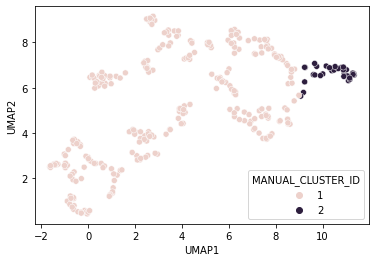

In [16]:
seaborn.scatterplot(
    x=nuclei_statistics["UMAP1"],
    y=nuclei_statistics["UMAP2"],
    hue=nuclei_statistics["MANUAL_CLUSTER_ID"],
)

## Cluster visualization in image space

In [17]:
# put a 0 for background in front
new_values = [0] + nuclei_statistics["MANUAL_CLUSTER_ID"].tolist()

print(new_values[:10])

[0, 1, 1, 1, 1, 1, 1, 1, 1, 1]


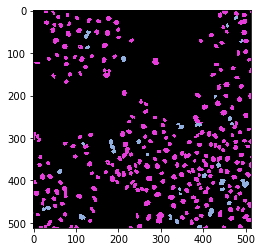

In [18]:
cluster_id_image = cle.replace_intensities(labels, new_values)
cle.imshow(cluster_id_image, labels=True)

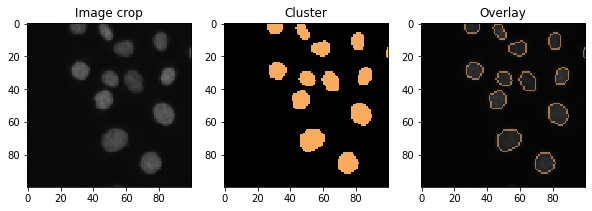

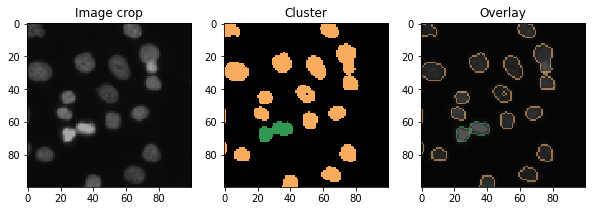

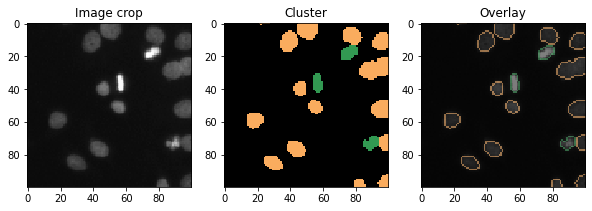

In [19]:
label_edges = cle.detect_label_edges(labels)
coloured_label_edges = label_edges * cluster_id_image

def show_crop(x=0, y=0, size=100):
    fig, axs = plt.subplots(1,3, figsize=(10,10))
    
    cle.imshow(image[x:x+size, y:y+size], plot=axs[0], 
               min_display_intensity=0,
               max_display_intensity=255)
    
    cle.imshow(cluster_id_image[x:x+size, y:y+size], labels=True, plot=axs[1], 
               min_display_intensity=0,
               max_display_intensity=3)

    cle.imshow(image[x:x+size, y:y+size], continue_drawing=True, plot=axs[2], 
               min_display_intensity=0,
               max_display_intensity=255)
    cle.imshow(coloured_label_edges[x:x+size, y:y+size], labels=True, alpha=0.5, 
               min_display_intensity=0,
               max_display_intensity=3,
                  plot=axs[2])
    
    axs[0].set_title("Image crop")
    axs[1].set_title("Cluster")
    axs[2].set_title("Overlay")
    

show_crop()
show_crop(400, 0)
show_crop(0, 400)

## Feature selection
When drawing UMAPs, it matters which parameters are selected. The procedure above demonstrates that it is possible to produce a UMAP and select a region in it which represents cells with a given phenontype. When choosing wrong parameters, a UMAP can still be generated but may not allow differentiating phenotypes. To demonstrate this, we take the result from the manual clustering step above as ground-truth for the next demonstration. We draw a UMAP from parameters which are supposedly not useful for differentiating phenotypes. In this UMAP, we will color the objects's manual cluster ID. Principal moments and axes are describing how cells are oriented in space. The phenotype mitotic vs. non-mitotic should not be related with on those parameters.

In [20]:
selected_statistics2 = nuclei_statistics[
    [
        "principal_moments0",
        "principal_moments1",
        "principal_axes0",
        "principal_axes1",
        "principal_axes2",
        "principal_axes3",
    ]
].values

scaled_statistics2 = StandardScaler().fit_transform(selected_statistics2)

type(scaled_statistics2), scaled_statistics2.shape

(numpy.ndarray, (320, 6))

C:\Users\rober\miniconda3\envs\bio_39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

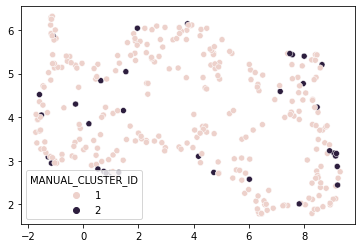

In [21]:
reducer = umap.UMAP()
embedding5 = reducer.fit_transform(scaled_statistics2)

seaborn.scatterplot(embedding5[:, 0], embedding5[:, 1], 
                    hue=nuclei_statistics["MANUAL_CLUSTER_ID"])

Thus, when experimenting with dimensionality reduction, it is always useful to have some annotasted datasets available. Without annotations and without the possibility to mark regions in the a UMAP, it may be hard to interpret these plots.

In [22]:
selected_statistics3 = nuclei_statistics[
    [
        "label",
        "minimum"
    ]
].values

scaled_statistics3 = StandardScaler().fit_transform(selected_statistics3)

type(scaled_statistics3), scaled_statistics3.shape

(numpy.ndarray, (320, 2))

## UMAPs of random and non-informative measurements
Our measurement table above also contains columns which may not at all be related to the phenotype. The column `label` is a subsequent enumeration of all object. Assuming the objects are enumerated in random order makes this effectively a random number. The used segmentation algorithm uses a thresholding technique under the hood. Thus, the minimum intensity of all segmented objects is presumably close to this threshold. This leads to the column `minimum` containing almost constant values with some random variation related to noise in the image. If we use such columns to generate a UMAP from, the algorithm will generate a snake-like arrangement of data points.

C:\Users\rober\miniconda3\envs\bio_39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

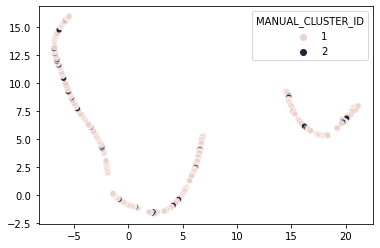

In [23]:
reducer = umap.UMAP()
embedding6 = reducer.fit_transform(scaled_statistics3)

seaborn.scatterplot(embedding6[:, 0], embedding6[:, 1], 
                    hue=nuclei_statistics["MANUAL_CLUSTER_ID"])

Interpreting this UMAP may not lead to reasonable results. Just as comparison, we draw the plot of the two selected columns.

<AxesSubplot:xlabel='label', ylabel='minimum'>

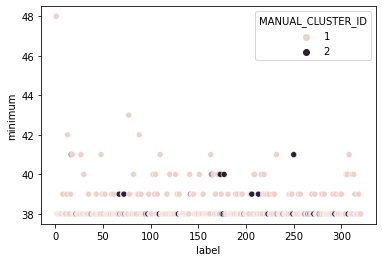

In [24]:
seaborn.scatterplot(x=nuclei_statistics["label"], 
                    y=nuclei_statistics["minimum"], 
                    hue=nuclei_statistics["MANUAL_CLUSTER_ID"])